In [1]:
#!pip install -q pandas==2.2.3 numpy==1.26.4 catboost==1.2.8 matplotlib==3.7.2 seaborn==0.12.2 dython==0.7.10 scikit-learn==1.2.2 joblib==1.5.1

In [3]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import Pool, CatBoostClassifier
import optuna
import joblib
from dython.nominal import associations # correlations
import warnings

In [4]:
# ignore warnings that don't affect accuracy
warnings.filterwarnings('ignore')

In [5]:
# pandas allow viewing of all columns of a df
pd.set_option('display.max_columns',None)

In [6]:
# specify data and resource paths
DATA_DESCRIPTION_PATH = '/kaggle/input/behold-data/data_desc.csv'
DATA_PATH = '/kaggle/input/behold-data/cumulative_2025.csv'

In [7]:
# view description of data columns
data_description = pd.read_csv(DATA_DESCRIPTION_PATH)
data_description

,Feature,Description
0,kepid,KepID
1,kepoi_name,KOI Name
2,kepler_name,Kepler Name
3,koi_disposition,Exoplanet Archive Disposition
4,koi_vet_stat,Vetting Status
...,...,...
77,koi_dicco_mdec,PRF &Delta;&delta;<sub>SQ</sub>(OOT) [arcsec]
78,koi_dicco_msky,PRF &Delta;&theta;<sub>SQ</sub>(OOT) []arcsec
79,koi_dikco_mra,PRF &Delta;&alpha;<sub>SQ</sub>(KIC) [arcsec]
80,koi_dikco_mdec,PRF &Delta;&delta;<sub>SQ</sub>(KIC) [arcsec]


In [8]:
# read and view full data
full_data = pd.read_csv(DATA_PATH,index_col=0)
full_data

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_longp,koi_impact,koi_duration,koi_ingress,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sage,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
rowid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,170.538750,2455003.539,0.0,NaN,0.146,2.95750,NaN,615.8,0.022344,3.20796,LS+MCMC,2.26,0.0853,89.66,793.0,93.59,24.810,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,4.467,0.14,0.927,0.919,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,48.141910,0.430,0.940,-0.000200,-0.000550,-0.010,0.200,0.200,0.080,0.310,0.320
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,162.513840,2454995.514,0.0,NaN,0.586,4.50700,NaN,874.8,0.027954,3.02368,LS+MCMC,2.83,0.2734,89.57,443.0,9.11,77.900,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,4.467,0.14,0.927,0.919,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,48.141990,-0.630,1.230,0.000660,-0.001050,0.390,0.000,0.390,0.490,0.120,0.500
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,DEEP_V_SHAPED,19.899140,175.850252,2455008.850,0.0,NaN,0.969,1.78220,NaN,10829.0,0.154046,7.29555,LS+MCMC,14.60,0.1419,88.96,638.0,39.30,53.500,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2711,0.3858,q1_q17_dr25_koi,37.159767,187.449100,76.3,1,56.0,1.0,q1_q17_dr25_tce,11111101110111011000000000000000,0.6624,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010811/010811496/dv/kplr010811496-20160209...,010/010811/010811496/dv/kplr010811496-001-2016...,5853.0,4.544,-0.18,0.868,0.961,NaN,q1_q17_dr25_stellar,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,48.134120,-0.021,-0.038,0.000700,0.000600,-0.025,-0.034,0.042,0.002,-0.027,0.027
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,0,0,q1_q17_dr25_sup_koi,MOD_ODDEVEN_DV---MOD_ODDEVEN_ALT---DEEP_V_SHAPED,1.736952,170.307565,2455003.308,0.0,NaN,1.276,2.40641,NaN,8079.2,0.387394,0.22080,LS+MCMC,33.46,0.0267,67.09,1395.0,891.96,3.278,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2865,0.3556,q1_q17_dr25_koi,39.066550,541.895100,505.6,1,621.0,1.0,q1_q17_dr25_tce,11111110111011101000000000000000,0.0000,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010848/010848459/dv/kplr010848459-20160209...,010/010848/010848459/dv/kplr010848459-001-2016

# EDA

## Sanitizing Target

Exploring the various columns that contain explicit disposition clues, we single out the desired target (koi_pdisposition) and drop all others (koi_disposition, koi_score, koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_co, and koi_fpflag_ec)

In [9]:
full_data = full_data.drop(columns=['koi_disposition','koi_score','koi_fpflag_nt','koi_fpflag_ss',
                          'koi_fpflag_co','koi_fpflag_ec'])

In [10]:
# viewing target distribution
target_dist = full_data['koi_pdisposition'].value_counts()
target_dist

koi_pdisposition
FALSE POSITIVE    4847
CANDIDATE         4717
Name: count, dtype: int64

<Axes: title={'center': 'TARGET DISTRIBUTION'}, xlabel='koi_pdisposition', ylabel='count'>

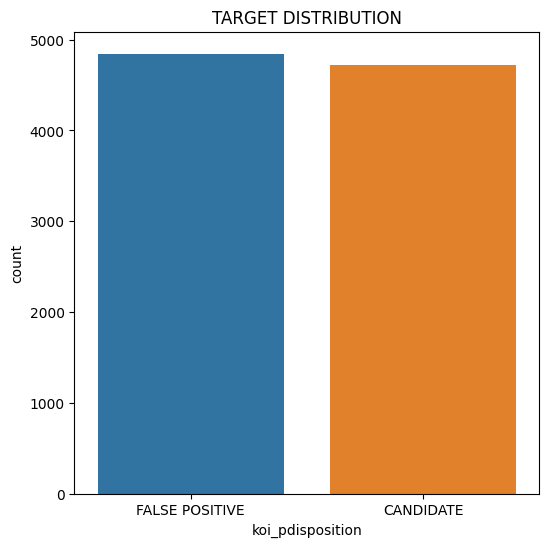

In [11]:
# visualising the target distribution
fig,ax = plt.subplots(figsize=(6,6))
plt.title('TARGET DISTRIBUTION')
sns.barplot(y=target_dist,
         x=target_dist.index,ax=ax)



In [12]:
# mapping target to numeric labels
TARGET_MAP = {'CANDIDATE':1,'FALSE POSITIVE':0}
full_data['koi_pdisposition'] = full_data['koi_pdisposition'].map(TARGET_MAP)

## Dropping Uninformative Features

### IDs
kepid

In [13]:
full_data = full_data.drop(columns=['kepid'])

### Features containing given-names
kepler_name,kepoi_name

In [14]:
full_data = full_data.drop(columns=['kepler_name','kepoi_name'])

In [15]:
full_data['koi_tce_delivname'].unique()

array(['q1_q17_dr25_tce', 'q1_q16_tce', nan, 'q1_q17_dr24_tce'],
      dtype=object)

### Irrelevant text-based data
'koi_disp_prov','koi_comment','koi_datalink_dvr','koi_datalink_dvs',koi_sparprov,koi_tce_delivname,koi_parm_prov

In [16]:
full_data = full_data.drop(columns=['koi_disp_prov','koi_comment',
                                   'koi_datalink_dvr','koi_datalink_dvs',
                                   'koi_sparprov','koi_tce_delivname',
                                   'koi_parm_prov'])

### Vetting-related Features
koi_vet_stat, koi_vet_date

In [17]:
full_data = full_data.drop(columns=['koi_vet_stat','koi_vet_date'])

### Single-Valued Features
- koi_limbdark_mod
- koi_trans_mod - 'Mandel and Agol (2002 ApJ 580 171)' and NaNs
- koi_longp - all Nans
- koi_eccen - 9200 0s and 363 NaNs



In [18]:
full_data = full_data.drop(columns=['koi_limbdark_mod','koi_eccen',
                                    'koi_trans_mod','koi_longp'])

## Sanitizing KOI_PERIOD

- It is not feasible that the kepler mission which lasted 9 years (about 3300 days) would capture an observation whose orbital period is greater than 3300
- This leads us to drop an observation whose orbital period is 129995.778400 days

In [19]:
full_data['koi_period'].describe()

count      9564.000000
mean         75.671358
std        1334.744046
min           0.241843
25%           2.733684
50%           9.752831
75%          40.715178
max      129995.778400
Name: koi_period, dtype: float64

In [20]:
full_data = full_data[~(full_data['koi_period']>3300)].reset_index(drop=True)

## Sanitizing Transit Epoch columns
- Transit Epoch in BKJD is the time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days. The offset corresponds to 12:00 on Jan 1, 2009 UTC
- having taken not of the inconsistencies in some of the calculations above, we recalculate koi_time0bk, maintain it and drop koi_time0

In [21]:
# inconsistency demonstrated
(full_data['koi_time0']-full_data['koi_time0bk']).nunique()

1925

In [22]:
# inconsistency corrected
full_data['koi_time0bk'] = full_data['koi_time0']-2454833
full_data = full_data.drop(columns=['koi_time0'])

## Encoding Categorical Columns

### koi_fittype

In [23]:
full_data['koi_fittype'].unique()

array(['LS+MCMC', 'MCMC', 'LS', 'none'], dtype=object)

In [24]:
FITTYPE_MAP = {'LS+MCMC':0, 'MCMC':1, 'LS':2, 'none':3}

In [25]:
full_data['koi_fittype'] = full_data['koi_fittype'].map(FITTYPE_MAP)

# FEATURE ENGINEERING

## Breaking down koi_quarters
koi_quarters bit string indicating which quarters of Kepler data were searched for transit signatures. Reading from left to right, the bits indicate the quarters, starting with quarter 1. A value of 1 for any bit means the designated quarter was searched for transits; a value of 0 means that quarter was not included in the transit search.

In [26]:
# the length of quarters string
full_data['quarters_str_len'] = np.where(full_data['koi_quarters'].isna(),np.nan,
                                    full_data['koi_quarters'].astype('str').str.len())

# number of quarters searched
full_data['quarters_searched'] = np.where(full_data['koi_quarters'].isna(),np.nan,
                                    full_data['koi_quarters'].apply(
                                        lambda x: np.sum([1 for v in str(x) if v=='1'])
                                        )
                                    )
full_data = full_data.drop('koi_quarters',axis=1)

## Planet classification quantitative criterion
based on Jean-Luc Margot's paper titled A Quantitative Criterion for Defining Planets

In [27]:
full_data['feedzone_mclear'] = 1.9*(10**-4)*((2*np.sqrt(3))**1.5)*(full_data['koi_smass']**(5/2))*(full_data['koi_sma']**(9/8))
full_data['stringent_mclear'] = 1.9*(10**-4)*(5**1.5)*(full_data['koi_smass']**2.5)*(full_data['koi_sma']**(9/8))

# Model Training and Evaluation

## Data Split

In [28]:
train,test = train_test_split(full_data,test_size=0.2,random_state=42,stratify=full_data['koi_pdisposition'])

In [29]:
# export train data
train.to_csv('train_data.csv',index=False)

## Feature Selection

In [30]:
X = train.drop(columns=['koi_pdisposition'])
y = train['koi_pdisposition']

In [31]:
cat_cols = ['koi_fittype']

After an extensively iterative feature selection process, the following 14 features were decided upon as the most relevant in predicting disposition: 

['koi_duration', 'koi_ror', 'koi_prad', 'koi_sma', 'koi_dor','koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_num_transits','koi_fwm_stat_sig', 'koi_fwm_sdec', 'koi_fwm_srao', 'koi_dicco_mra','koi_dikco_msky']


Training with these relevant features on a baseline set of 5 catboost classifiers all with hyperparameters of {'iterations': 800,'learning_rate': 0.05,'depth': 5,'objective': 'Logloss','eval_metric': 'Logloss','random_seed': 42,'task_type':'CPU','use_best_model':False} yields a 5-fold cross-validation score of 0.8976506018073707

In [32]:
baseline_hyperparameters = {'iterations': 800,'learning_rate': 0.05,'depth': 5,
                            'objective': 'Logloss','eval_metric': 'Logloss',
                            'random_seed': 42,'task_type':'CPU','use_best_model':False}

In [33]:
sel_ind = ['koi_duration', 'koi_ror', 'koi_prad', 'koi_sma', 'koi_dor',
           'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_num_transits',
           'koi_fwm_stat_sig', 'koi_fwm_sdec', 'koi_fwm_srao', 'koi_dicco_mra',
           'koi_dikco_msky']

## Hyperparameter Optimization
To achieve improved accuracy, an optuna hyperparameter study was created to search for hyperparameter values optimized for F1 score on this specific training data

In [34]:
optimized_hyperparameters =  {'iterations': 945, 'learning_rate': 0.0633262487790528,
                              'max_depth': 6, 'l2_leaf_reg': 0.9155184101187535,
                              'min_data_in_leaf': 90,
                              'colsample_bylevel': 0.7583283066319525,
                              'bootstrap_type': 'Bayesian'}

The resulting optimized hyperparameter improved the model cross-validation f1 score to 0.8990435482235679

## Model Training

In [35]:
scv = StratifiedKFold(n_splits=5)
fit_models = []
ll_scores = []
train_scores = []

for train_index, test_index in scv.split(X, y):

    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

    
    preppedtrain_sel = X_train[sel_ind]
    preppedtest_sel = X_test[sel_ind]

    cat_features = [i for i, col in enumerate(sel_ind) if col in cat_cols]
            
    train_pool = Pool(preppedtrain_sel, y_train,cat_features=cat_features)
    test_pool = Pool(preppedtest_sel, y_test, cat_features=cat_features)
    
    model = CatBoostClassifier(objective='Logloss',task_type='CPU',
                              random_state=42, silent=True,**optimized_hyperparameters
                              )
    

    model.fit(train_pool,eval_set=test_pool)
    
    
    fit_models.append(model)


    y_pred = model.predict(preppedtest_sel)


    indcv = f1_score(y_test,y_pred)
    tr_cv = f1_score(y_train,model.predict(preppedtrain_sel))

    ll_scores.append(indcv)
    train_scores.append(tr_cv)


print('mean 5fold rmse train: ', np.mean(train_scores))
print('mean 5fold rmse test: ', np.mean(ll_scores))

mean 5fold rmse train:  0.9768224903857525
mean 5fold rmse test:  0.8990435482235679


In [36]:
# export models
joblib.dump(fit_models,'exoplanet_models.pkl')

['exoplanet_models.pkl']

## Model Testing

In [37]:
loaded_models = joblib.load('exoplanet_models.pkl')

In [38]:
test = test.reset_index(drop=True)

In [39]:
# export test data
test.to_csv('test_data.csv',index=False)

In [40]:
# generating test data predictions
preds = {}
for i,model in enumerate(loaded_models):
    preds[i] = model.predict(test[sel_ind]).ravel()

In [41]:
pred_df = pd.DataFrame(preds)
test['prediction'] = pred_df.mode(axis=1)[0]

In [42]:
f1_score(test['koi_pdisposition'],test['prediction'])

0.8932346723044398

- Train score: 0.977
- Cross validation score (5fold): 0.899
- Test score: 0.893

## Feature Importance

In [43]:
final_feature_imps = []
for model in fit_models:
    final_feature_imps.append(model.get_feature_importance())

final_feature_imps = np.mean(np.array(final_feature_imps),axis=0)

In [44]:
final_feature_imps = dict(zip(train_pool.get_feature_names(),final_feature_imps))

In [45]:
final_feature_imp_df = pd.DataFrame(final_feature_imps,
                                    index=['feature_importance']).T.sort_values('feature_importance',
                                                                                ascending=False)
final_feature_imp_df

,feature_importance
koi_dikco_msky,13.927084
koi_prad,13.411879
koi_dor,9.647472
koi_ror,9.452977
koi_duration,6.859429
koi_max_mult_ev,6.025547
koi_dicco_mra,5.740354
koi_model_snr,5.706924
koi_fwm_srao,5.597182
koi_fwm_stat_sig,5.332881


In [46]:
#export feature importance
final_feature_imp_df.to_csv('feature_importance.csv')